In [1]:
import ROOT as R
import ctypes
import math

# R.gStyle.SetOptStat(0)
#%jsroot on

Welcome to JupyROOT 6.24/00


## this a fsdafdsf

In [2]:
#predefine variables
cyclotron = 0.149 # micro-second
gamma = 29.3
omega_a_ref =  2 * math.pi / (gamma * cyclotron)
e_thresh = 1650

In [3]:
tfile = R.TFile('../Data/ETout.root')

## Collect ET histograms

In [4]:
#collect histos
th2_all = tfile.Get('all')
th2_calos = []
for n in range(24):
    th2_calo = tfile.Get('ET%s'%(n+1))
    th2_calos.append(th2_calo)

time start at       29.094 micro-second
time end at         671.5492 micro-second
time bin width      0.1492 micro-second
energy bin width    10.0 MeV


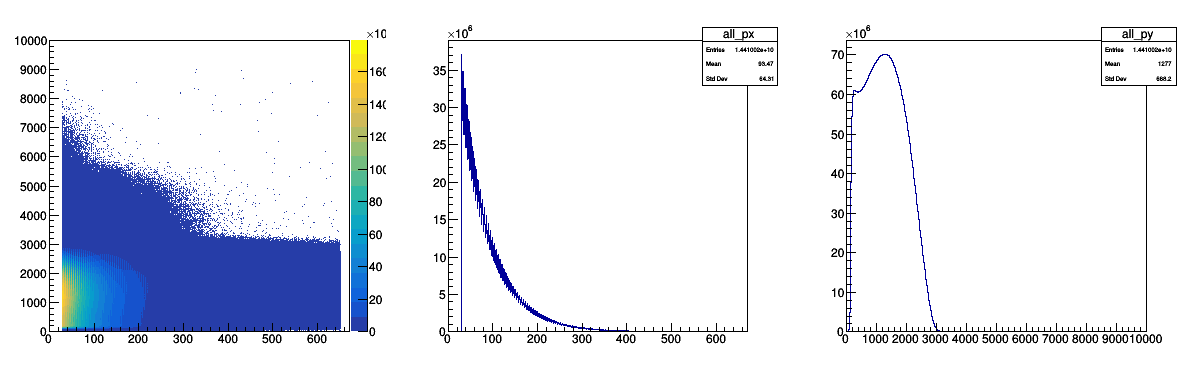

In [5]:
#get binning info
time_dist_all = th2_all.ProjectionX()
t_nbins = time_dist_all.GetNbinsX()
t_bin_width = time_dist_all.GetBinWidth(1)
t_start = -1.
t_end = time_dist_all.GetBinLowEdge(t_nbins+1) + t_bin_width 
for n in range(t_nbins):
    N = time_dist_all.GetBinContent(n+1)
    if N > 100:
        t_start = time_dist_all.GetBinLowEdge(n+1)        
        break
t_start += t_bin_width
e_dist_all = th2_all.ProjectionY()
e_bin_width = e_dist_all.GetBinWidth(1)
print 'time start at       %s micro-second'%(t_start)
print 'time end at         %s micro-second'%(t_end)
print 'time bin width      %s micro-second'%(t_bin_width)
print 'energy bin width    %s MeV'%(e_bin_width)

#draw hists
canvas = R.TCanvas('c1','c1',1200,400)
canvas.Divide(3)
canvas.cd(1)
th2_all.Draw("COLZ")
canvas.cd(2)
time_dist_all.Draw()
canvas.cd(3)
e_dist_all.Draw()
canvas.Draw()

In [6]:
#names convention
names = ['N','tau','Ac','As','R']
namesPhase = ['N','tau','A','phi','R']

#build fit phase-fit model 
five_param_phase_str = '[0]*exp(-x/[1])*(1+[2]*cos(x*[5]*(1+[4]*1e-6)-[3]))'
phase_fit = R.TF1('phasefit', five_param_phase_str, t_start, t_end)
phase_fit.SetParNames('N', '#tau', 'A', '#phi', 'R', '#omega_{a} ref')
phase_fit.SetParameters(5e+7, 66.38, 0.2, 0, 116., omega_a_ref)
phase_fit.FixParameter(5, omega_a_ref)
phase_fit.SetParLimits(3, -math.pi/2-0.1, math.pi/2+0.1)
phase_fit.SetNpx(1000)

#build fit A_s*sin+A_c*cos model
five_param_str = '[0]*exp(-x/[1])*(1+[2]*cos(x*[5]*(1+[4]*1e-6))+[3]*sin(x*[5]*(1+[4]*1e-6)))'
cos_sin_fit = R.TF1('cos_sin_fit', five_param_str, t_start, t_end)
cos_sin_fit.SetParNames('N', '#tau', 'A_{c}', 'A_{s}', 'R', '#omega_{a} ref')
cos_sin_fit.SetParameters(5e+7, 66.38, 0.2, 0, 116., omega_a_ref)
cos_sin_fit.FixParameter(5, omega_a_ref)
cos_sin_fit.SetNpx(1000)

#build fit phase-fit w_a model 
five_param_phase_str = '[0]*exp(-x/[1])*(1+[2]*cos(x*[4]-[3]))'
phase_wa_fit = R.TF1('phasefit', five_param_phase_str, t_start, t_end)
phase_wa_fit.SetParNames('N', '#tau', 'A', '#phi', '#omega_{a}')
phase_wa_fit.SetParameters(5e+7, 66.38, 0.2, 0, omega_a_ref)
phase_wa_fit.SetParLimits(3, -math.pi/2-0.1, math.pi/2+0.1)
phase_wa_fit.SetNpx(1000)

#build fit A_s*sin+A_c*cos w_a model
five_param_str = '[0]*exp(-x/[1])*(1+[2]*cos(x*[4])+[3]*sin(x*[4]))'
cos_sin_wa_fit = R.TF1('cos_sin_fit', five_param_str, t_start, t_end)
cos_sin_wa_fit.SetParNames('N', '#tau', 'A_{c}', 'A_{s}', '#omega_{a}')
cos_sin_wa_fit.SetParameters(5e+7, 66.38, 0.2, 0, omega_a_ref)
cos_sin_wa_fit.SetNpx(1000)



define string that will be used to generate 5-parameter fitFunc.functions of the form $N_0 \cdot \exp(-t/\tau) \cdot \left[1 + A_c \cos(\omega_a t) + A_s\sin(\omega_a t)\right]$.
$\omega_a$ will be parameterized as $\omega_{a,ref} (1 + \textrm{R})$, with R in ppm.

In [7]:
five_param_str = '[0]*exp(-x/[1])*(1+[2]*cos(x*[5]*(1+[4]*1e-6))+[3]*sin(x*[5]*(1+[4]*1e-6)))'

 FCN=28217.8 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         446 TOTAL
                     EDM=1.42888e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            5.22355e+07   7.68978e+02   4.92083e-03  -6.63838e-13
   2  #tau         6.45154e+01   5.39462e-04  -7.16261e-09   4.43463e-06
   3  A_{c}       -6.72471e-02   1.84864e-05   1.07567e-09   1.67563e-04
   4  A_{s}       -1.00135e-01   1.50853e-05   1.59204e-09   4.92158e-05
   5  R            1.16628e+02   1.05392e+00   1.05392e+00  -1.69422e-08
   6  p5           1.43922e+00     fixed    


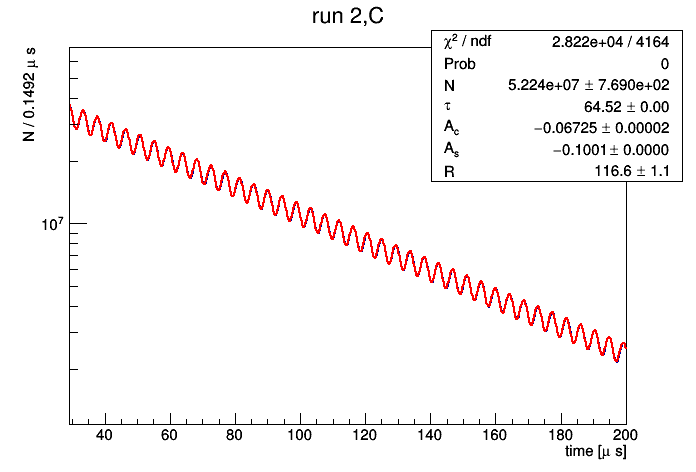

In [8]:
#fit wiggle plot
c = R.TCanvas()
wiggle_hist = th2_all.ProjectionX()
fitFunc = R.TF1('fitFunc',five_param_str,t_start, t_end)
R.gStyle.SetOptFit(1111)
R.gStyle.SetOptStat(0)
fitFunc.SetNpx(1000)
fitFunc.SetParName(0, "N")
fitFunc.SetParName(1, "#tau")
fitFunc.SetParName(2, "A_{c}")
fitFunc.SetParName(3, "A_{s}")
fitFunc.SetParName(4, "R")
fitFunc.SetLineColor(R.kRed)
fitFunc.SetParameters(35e+6, 66.38, 0.4, 0.0, 433, omega_a_ref)
fitFunc.FixParameter(5, omega_a_ref)
wiggle_hist.Fit(fitFunc, "EM",'',t_start,t_end)
wiggle_hist.SetTitle('run 2,C; time [#mu s]; N / {0} #mu s'.format(t_bin_width))
wiggle_hist.GetYaxis().SetTitleOffset(1)
R.gPad.SetLogy(1)
wiggle_hist.GetXaxis().SetRangeUser(t_start,200)
wiggle_hist.GetXaxis().SetRangeUser(t_start,200)
wiggle_hist.SetStats(0)
wiggle_hist.SetStats(1)
c.Draw()

In [9]:
#start time scan
parameter_graphs = [R.TGraphErrors() for n in range(5)]
upper_bound_graphs = [R.TGraph() for n in range(5)]
lower_bound_graphs = [R.TGraph() for n in range(5)]
start_values = []
start_errors = []
for m in range(5):
        parameter_graphs[m].SetTitle(';start time [#mu s];{0}'.format(fitFunc.GetParName(m)))
        upper_bound_graphs[m].SetLineStyle(2)
        lower_bound_graphs[m].SetLineStyle(2)        
#scan 300*0.1492 [#mu s]
start_values = []
start_errors = []
for n in range(0,300):
    this_start = t_start + (n+1) * t_bin_width
    wiggle_hist.Fit(fitFunc,'EMQ','',this_start,t_end)
    for m in range(5):
        value = fitFunc.GetParameter(m)
        error = fitFunc.GetParError(m)
        if n == 0:
            start_values.append(value)
            start_errors.append(error)
        parameter_graphs[m].SetPoint(n,this_start,value)
        parameter_graphs[m].SetPointError(n,0.,error)
        variance_drift = fitFunc.GetParError(m)**2 - start_errors[m]**2
        error_drift = 0. if variance_drift < 0. else variance_drift**0.5
        lower_bound_graphs[m].SetPoint(n,this_start,start_values[m] - error_drift)
        upper_bound_graphs[m].SetPoint(n,this_start,start_values[m] + error_drift)

In [10]:
#dump start time scan results
tfile_out = R.TFile('omegaA_output.root','recreate')
tfile_out.cd()
for n in range(5):
    name_temp = 'starttime_%s_%s'
    parameter_graphs[n].SetName(name_temp%(names[n],'graph'))
    upper_bound_graphs[n].SetName(name_temp%(names[n],'upper'))
    lower_bound_graphs[n].SetName(name_temp%(names[n],'lower'))
    parameter_graphs[n].Write()
    upper_bound_graphs[n].Write()
    lower_bound_graphs[n].Write()

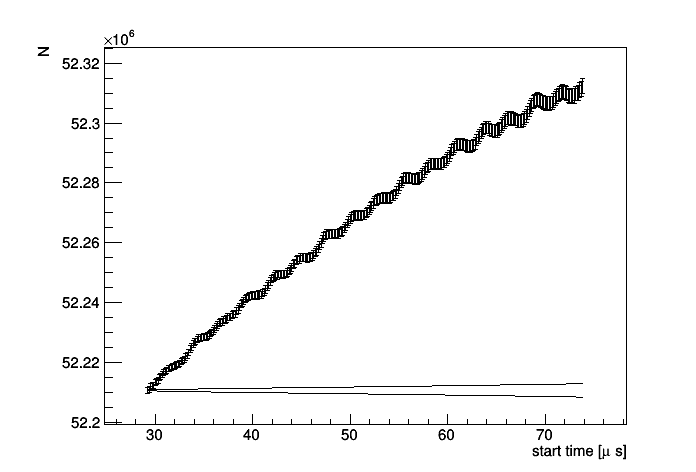

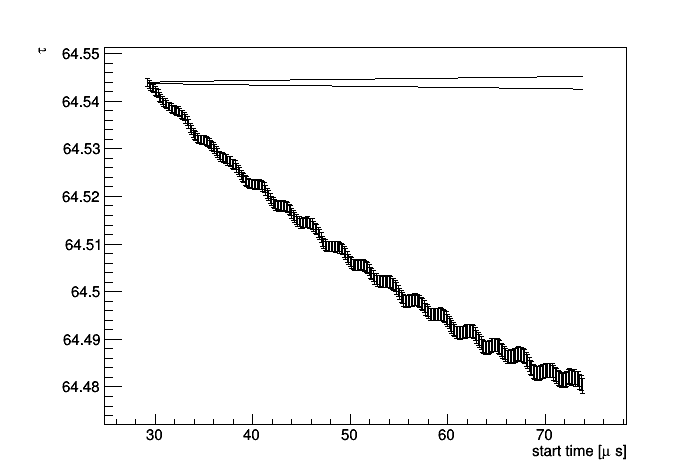

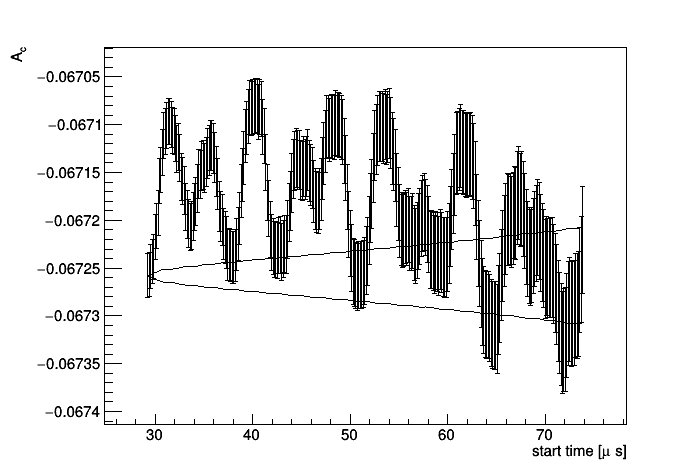

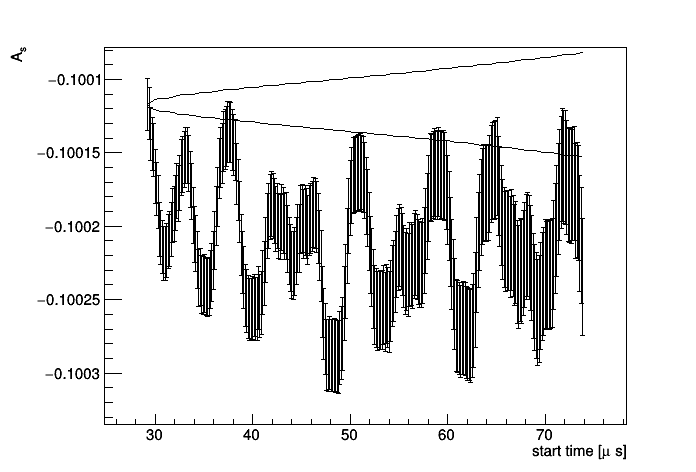

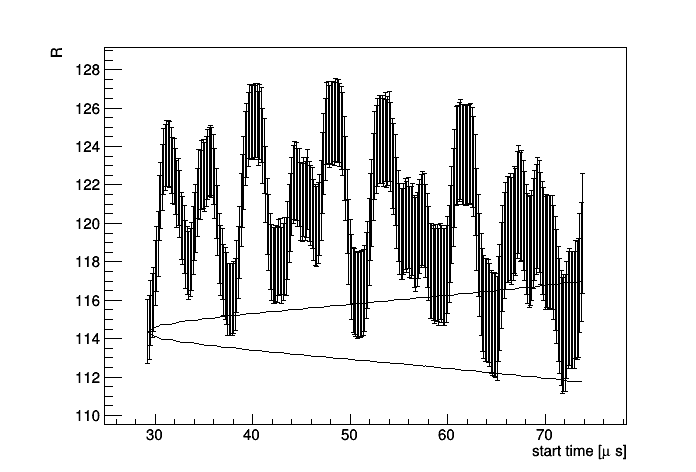

In [11]:
#draw start time scan
canvases = []
for i in range(5):
    canvases.append(R.TCanvas())
    canvases[i].SetLeftMargin(0.15)
    parameter_graphs[i].GetXaxis().SetTitleOffset(0)
    parameter_graphs[i].Draw("ap")
    upper_bound_graphs[i].Draw("l same")
    lower_bound_graphs[i].Draw("l same")
    canvases[i].Draw()

In [12]:
#energy threshold scan
central_graphs = [R.TGraphErrors() for n in range(5)]
error_graphs = [R.TGraph() for n in range(5)]
name_temp = 'energythreshold_%s_%s'
#setup graphs
for n in range(5):
    central_graphs[n].SetName(name_temp%(names[n],'graph'))
    error_graphs[n].SetName(name_temp%(names[n],'error'))
    central_graphs[n].SetTitle(';%s;%s'%('Energy threshold [MeV]',names[n]))
    error_graphs[n].SetTitle(';%s;%s'%('Energy threshold [MeV]',names[n]))
NbinsY = th2_all.GetNbinsY()
#do scan
fitFunc.SetParameters(35e+6, 66.38, 0.4, 0.0, 433, omega_a_ref)
for n in range(0,200):
    this_threshold = (n+50) * e_bin_width
    wiggle = th2_all.ProjectionX('wiggle_energy_thres_%s_mev'%(this_threshold),n+50,NbinsY)
    wiggle.Fit(fitFunc,'EMQ','',t_start,t_end)
    for m in range(5):
        value = fitFunc.GetParameter(m)
        error = fitFunc.GetParError(m)
        # if m==4:
        #     print '{0:<.3f}   {1:<.3f}'.format(value,error)
        central_graphs[m].SetPoint(n,this_threshold,value)
        central_graphs[m].SetPointError(n,0.,error)
        error_graphs[m].SetPoint(n,this_threshold,error)

In [13]:
def Draw_graph_and_error(central_graph,error_graph,isMeanLine=False,legPos=[0.43,0.77],error_name='Uncertainty'):
    if isMeanLine:
        central_graph.Fit('pol0','Q')
        funcLine = central_graph.GetFunction('pol0')
        funcLine.SetLineColor(R.kBlue)
        funcLine.SetLineWidth(1)
        funcLine.SetLineStyle(4)

    lineWidth = 1 if not isMeanLine else 2
    R.gStyle.SetOptStat(0)
    R.gStyle.SetOptFit(0)
    c = R.TCanvas()    
    central_graph.SetMarkerSize(1)
    central_graph.SetMarkerStyle(2)
    central_graph.SetLineWidth(lineWidth)
    error_graph.SetLineColor(2)
    error_graph.SetLineWidth(lineWidth)
    p1 = R.TPad("p1", "", 0, 0, 1, 1);
    p1.SetGrid();
    p1.Draw();
    p1.cd();
    central_graph.Draw("AC");
    central_graph.GetHistogram().GetXaxis().SetTitleOffset(1.25);
    central_graph.GetHistogram().GetYaxis().SetTitleOffset(1.25);
    R.gPad.Update();
    p2 = R.TPad("p2", "", 0, 0, 1, 1);
    p2.SetFillStyle(4000)
    xmin = p1.GetUxmin();
    xmax = p1.GetUxmax();
    ymin = error_graph.GetHistogram().GetMinimum();
    ymax = error_graph.GetHistogram().GetMaximum();
    dx = (xmax - xmin) / 0.8; # 10 percent margins left and right
    dy = (ymax - ymin) / 0.8; # 10 percent margins top and bottom
    p2.Range(xmin-0.1*dx, ymin-0.1*dy, xmax+0.1*dx, ymax+0.1*dy);
    p2.Draw();
    p2.cd();
    error_graph.Draw("LP");
    R.gPad.Update();    
    axis = R.TGaxis(xmax, ymin, xmax, ymax, ymin, ymax, 510, "+L");
    axis.SetTitleColor(R.kRed);
    axis.SetLabelColor(R.kRed);
    axis.SetLineColor(R.kRed);
    axis.Draw();
    R.gPad.Update();
    # leg = R.TLegend(0.43, 0.77, 0.78, 0.90);
    leg = R.TLegend(legPos[0], legPos[1], legPos[0]+0.35, legPos[1]+0.13);
    leg.SetFillColor(R.gPad.GetFillColor());
    leg.SetTextAlign(22);
    leg.AddEntry(central_graph, "Central value", "EP");
    leg.AddEntry(error_graph, "Uncertainty", "L");
    if isMeanLine:
        leg.AddEntry(funcLine,'weighted mean value','L')

    leg.Draw();
    R.gPad.Update();    
    c.cd();
    return [c,leg,axis]

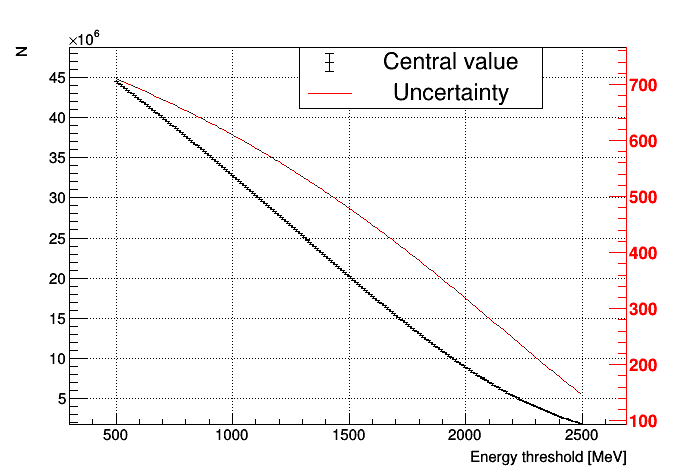

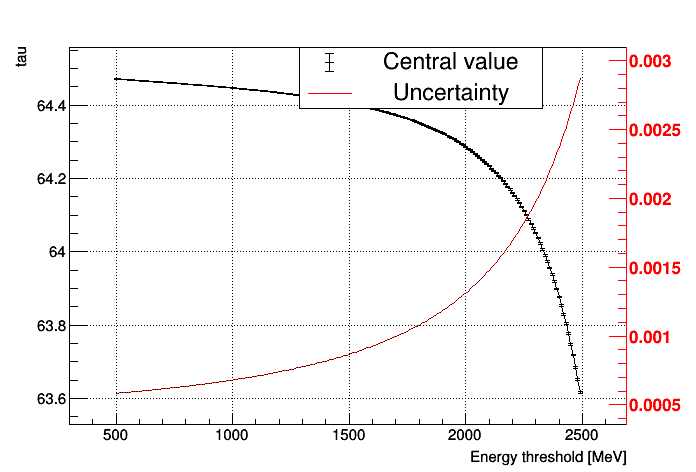

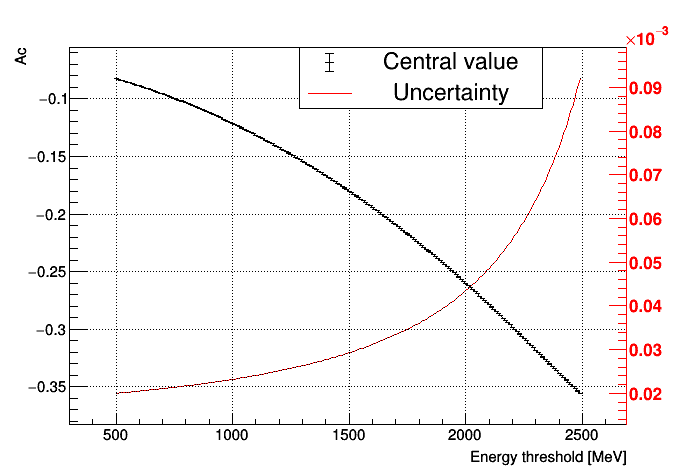

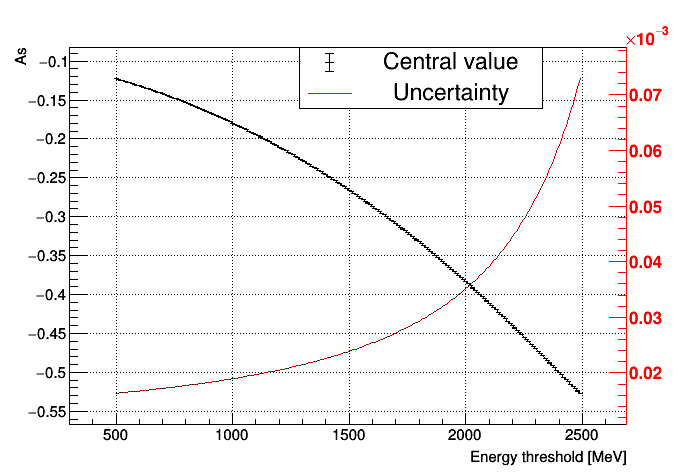

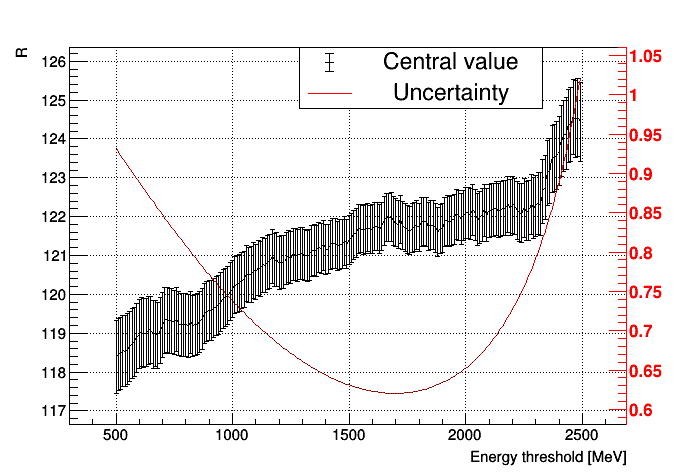

In [14]:
canvas = []
for n in range(5):
    central_graphs[n].SetTitle(';%s;%s'%('Energy threshold [MeV]',names[n]))
    c = Draw_graph_and_error(central_graphs[n],error_graphs[n])
    canvas.append(c)
    canvas[n][0].Draw()
    

In [15]:
#20 slices with equal bin numbers
#from 100 MeV to 3100 MeV
energy_bin_shift = 10
bin_limits = []
for n in range(20):
    bin_limit_low  = energy_bin_shift + n*15 + 1
    bin_limit_high = energy_bin_shift + (n+1)*15
    bin_limits.append([bin_limit_low,bin_limit_high])
print bin_limits

[[11, 25], [26, 40], [41, 55], [56, 70], [71, 85], [86, 100], [101, 115], [116, 130], [131, 145], [146, 160], [161, 175], [176, 190], [191, 205], [206, 220], [221, 235], [236, 250], [251, 265], [266, 280], [281, 295], [296, 310]]


In [16]:
#20 slices with equal entries
#from 100 MeV to 3100 MeV
e_dist = th2_all.ProjectionY()
Ntotal = e_dist.Integral(11,310) # from 100 to 3100 MeV
N_per_Slice = Ntotal/20.
print N_per_Slice
bin_limits_equal = []
bin_limit_low = 11
bin = 11
while bin < 311:
    integral = e_dist.Integral(bin_limit_low,bin)
    integral_next = e_dist.Integral(bin_limit_low,bin+1)
    if bin == 310:
        if len(bin_limits_equal) == 20:
            bin_limits_equal[19][1] = bin
            bin_limits_equal[19][2] += integral
        else:
            bin_limits_equal.append([bin_limit_low,bin,integral])
        bin += 1

    elif integral<N_per_Slice and integral_next>N_per_Slice:
        if N_per_Slice - integral < integral_next - N_per_Slice:
            bin_limits_equal.append([bin_limit_low,bin,integral])
            bin += 1        
        else:
            bin_limits_equal.append([bin_limit_low,bin+1,integral_next])
            bin += 2
        bin_limit_low = bin
    else:
        bin += 1

print bin_limits_equal
print len(bin_limits_equal)

719818293.6
[[11, 26, 729816338.0], [27, 38, 729775715.0], [39, 50, 729899255.0], [51, 62, 743101997.0], [63, 73, 699581036.0], [74, 84, 719171043.0], [85, 95, 737874137.0], [96, 106, 753647871.0], [107, 116, 695215120.0], [117, 126, 700935961.0], [127, 136, 701674921.0], [137, 146, 696607633.0], [147, 157, 752718681.0], [158, 168, 729672625.0], [169, 179, 697637011.0], [180, 191, 714886630.0], [192, 204, 706466913.0], [205, 219, 703777837.0], [220, 239, 718236612.0], [240, 310, 735668536.0]]
20


In [17]:
def PhaseFit(wiggle,fitModel,t_start,t_end):
    wiggle.Fit(fitModel,'EMQ','',t_start,t_end)
    phi = fitModel.GetParameter(3)
    if phi < - math.pi/2:    
        fitModel.SetParameter(3,phi+math.pi)
        fitModel.SetParameter(2,0.-fitModel.GetParameter(2))
        wiggle.Fit(fitModel,'EMQ','',t_start,t_end)
    elif phi > math.pi/2: 
        fitModel.SetParameter(3,phi-math.pi)
        fitModel.SetParameter(2,0.-fitModel.GetParameter(2))
        wiggle.Fit(fitModel,'EMQ','',t_start,t_end)
    


def FitScan_energySlices(bin_limit,hist_2d,fitModel):
    energy_low = int((bin_limit[0]-1) * e_bin_width)
    energy_high = int(bin_limit[1] * e_bin_width)
    slice_name = 'Slice_%s_%s_MeV'%(energy_low,energy_high)
    wiggle = hist_2d.ProjectionX(slice_name,bin_limit[0],bin_limit[1])
    fitModel.SetNpx(1000)
    wiggle.SetTitle('{0:}; time [#mu s]; N / {1} #mu s'.format(slice_name, t_bin_width))
    PhaseFit(wiggle,fitModel,t_start,t_end)
    # wiggle.Fit(fitModel,'EMQ','',t_start,t_end)
    # phi = fitModel.GetParameter(3)
    # if phi < - math.pi/2:    
    #     fitModel.SetParameter(3,phi+math.pi)
    #     fitModel.SetParameter(2,0.-fitModel.GetParameter(2))
    #     wiggle.Fit(fitModel,'EMQ','',t_start,t_end)
    # elif phi > math.pi/2: 
    #     fitModel.SetParameter(3,phi-math.pi)
    #     fitModel.SetParameter(2,0.-fitModel.GetParameter(2))
    #     wiggle.Fit(fitModel,'EMQ','',t_start,t_end)
    return wiggle

In [18]:
# #cos+sin fit overall
# canvas = R.TCanvas()
# wiggle = th2_all.ProjectionX()
# wiggle.Fit(cos_sin_fit,'EM','',t_start,t_end)
# wiggle.GetXaxis().SetRangeUser(t_start,200)
# R.gPad.SetLogy(1)
# wiggle.Draw()
# canvas.Draw()

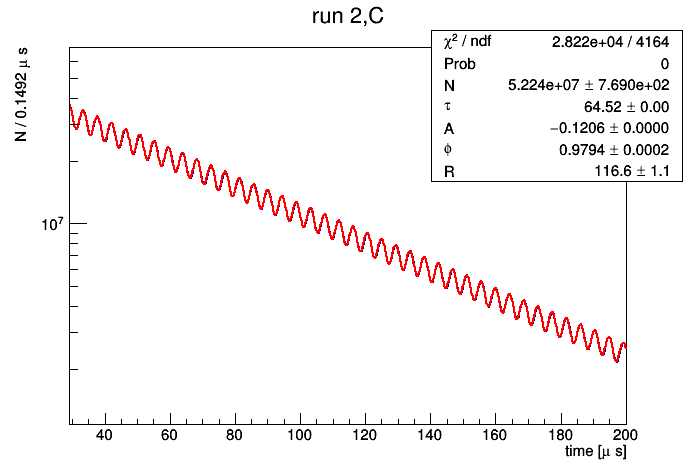

In [19]:
#phase fit overall
R.gStyle.SetOptFit(1111)
canvas = R.TCanvas()
wiggle = th2_all.ProjectionX()
PhaseFit(wiggle,phase_fit,t_start,t_end)
wiggle.GetXaxis().SetRangeUser(t_start,200)
wiggle.SetTitle('run 2,C; time [#mu s]; N / {0} #mu s'.format(t_bin_width))
R.gPad.SetLogy(1)
# wiggle.SetStats(1)
wiggle.Draw()
canvas.Draw()

In [20]:
# canvases = []
# hists = []
# phase_fit.SetParameters(5e+7, 66.38, 0.1, 0.1, 116.,omega_a_ref)
# for bin_limit in bin_limits:
#     canvases.append(R.TCanvas())
#     wiggle = FitScan_energySlices(bin_limit,th2_all,phase_fit)
#     wiggle.GetXaxis().SetRangeUser(50,150)
#     wiggle.Draw()
#     hists.append(wiggle)
#     canvases[-1].Draw()

In [21]:
# central_graphs = [R.TGraphErrors()]
# error_graphs = []
# canv = r.TCanvas()
# rvsE_graph = r.TGraphErrors()
# rvsE_graph.SetTitle('R versus E bin; energy bin center [MeV]; R')
# for hist, E in zip(hists, centers):
#     fit_func = hist.GetFunction('phasefit')
#     if fit_func.GetParError(4) < 1000 and abs(fit_func.GetParameter(4))<1000:
#         rvsE_graph.SetPoint(rvsE_graph.GetN(), E, fit_func.GetParameter(4))
#         rvsE_graph.SetPointError(rvsE_graph.GetN()-1, 0, fit_func.GetParError(4))
# rvsE_graph.Fit('pol0')
# rvsE_graph.Draw('ap')
# canv.Draw()
# canv.Print('rVersusEBinSuperbowl.pdf')

In [22]:
#energy slices scan
central_graphs_eslice_e = [R.TGraphErrors() for n in range(5)]
error_graphs_eslice_e = [R.TGraph() for n in range(5)]
name_temp = 'E_slices_%s_%s'
#setup graphs 
for n in range(5):
    central_graphs_eslice_e[n].SetName(name_temp%(namesPhase[n],'graph'))
    error_graphs_eslice_e[n].SetName(name_temp%(namesPhase[n],'error'))
    central_graphs_eslice_e[n].SetTitle(';%s;%s'%('Energy bin center [MeV]',namesPhase[n]))
    error_graphs_eslice_e[n].SetTitle(';%s;%s'%('Energy bin center [MeV]',namesPhase[n]))
#do scan
hists_eslice_e = []
phase_fit.SetParameters(5e+7, 66.38, 0.1, 0.1, 116.,omega_a_ref)
for nSlice,bin_limit in enumerate(bin_limits):
    e_bin_center = ( bin_limit[0] + bin_limit[1] - 1. )*e_bin_width/2.    
    wiggle = FitScan_energySlices(bin_limit,th2_all,phase_fit)    
    hists_eslice_e.append(wiggle)
    for n in range(5):
        value = phase_fit.GetParameter(n)
        error = phase_fit.GetParError(n)
        central_graphs_eslice_e[n].SetPoint(nSlice,e_bin_center,value)
        central_graphs_eslice_e[n].SetPointError(nSlice,0.,error)
        error_graphs_eslice_e[n].SetPoint(nSlice,e_bin_center,error)

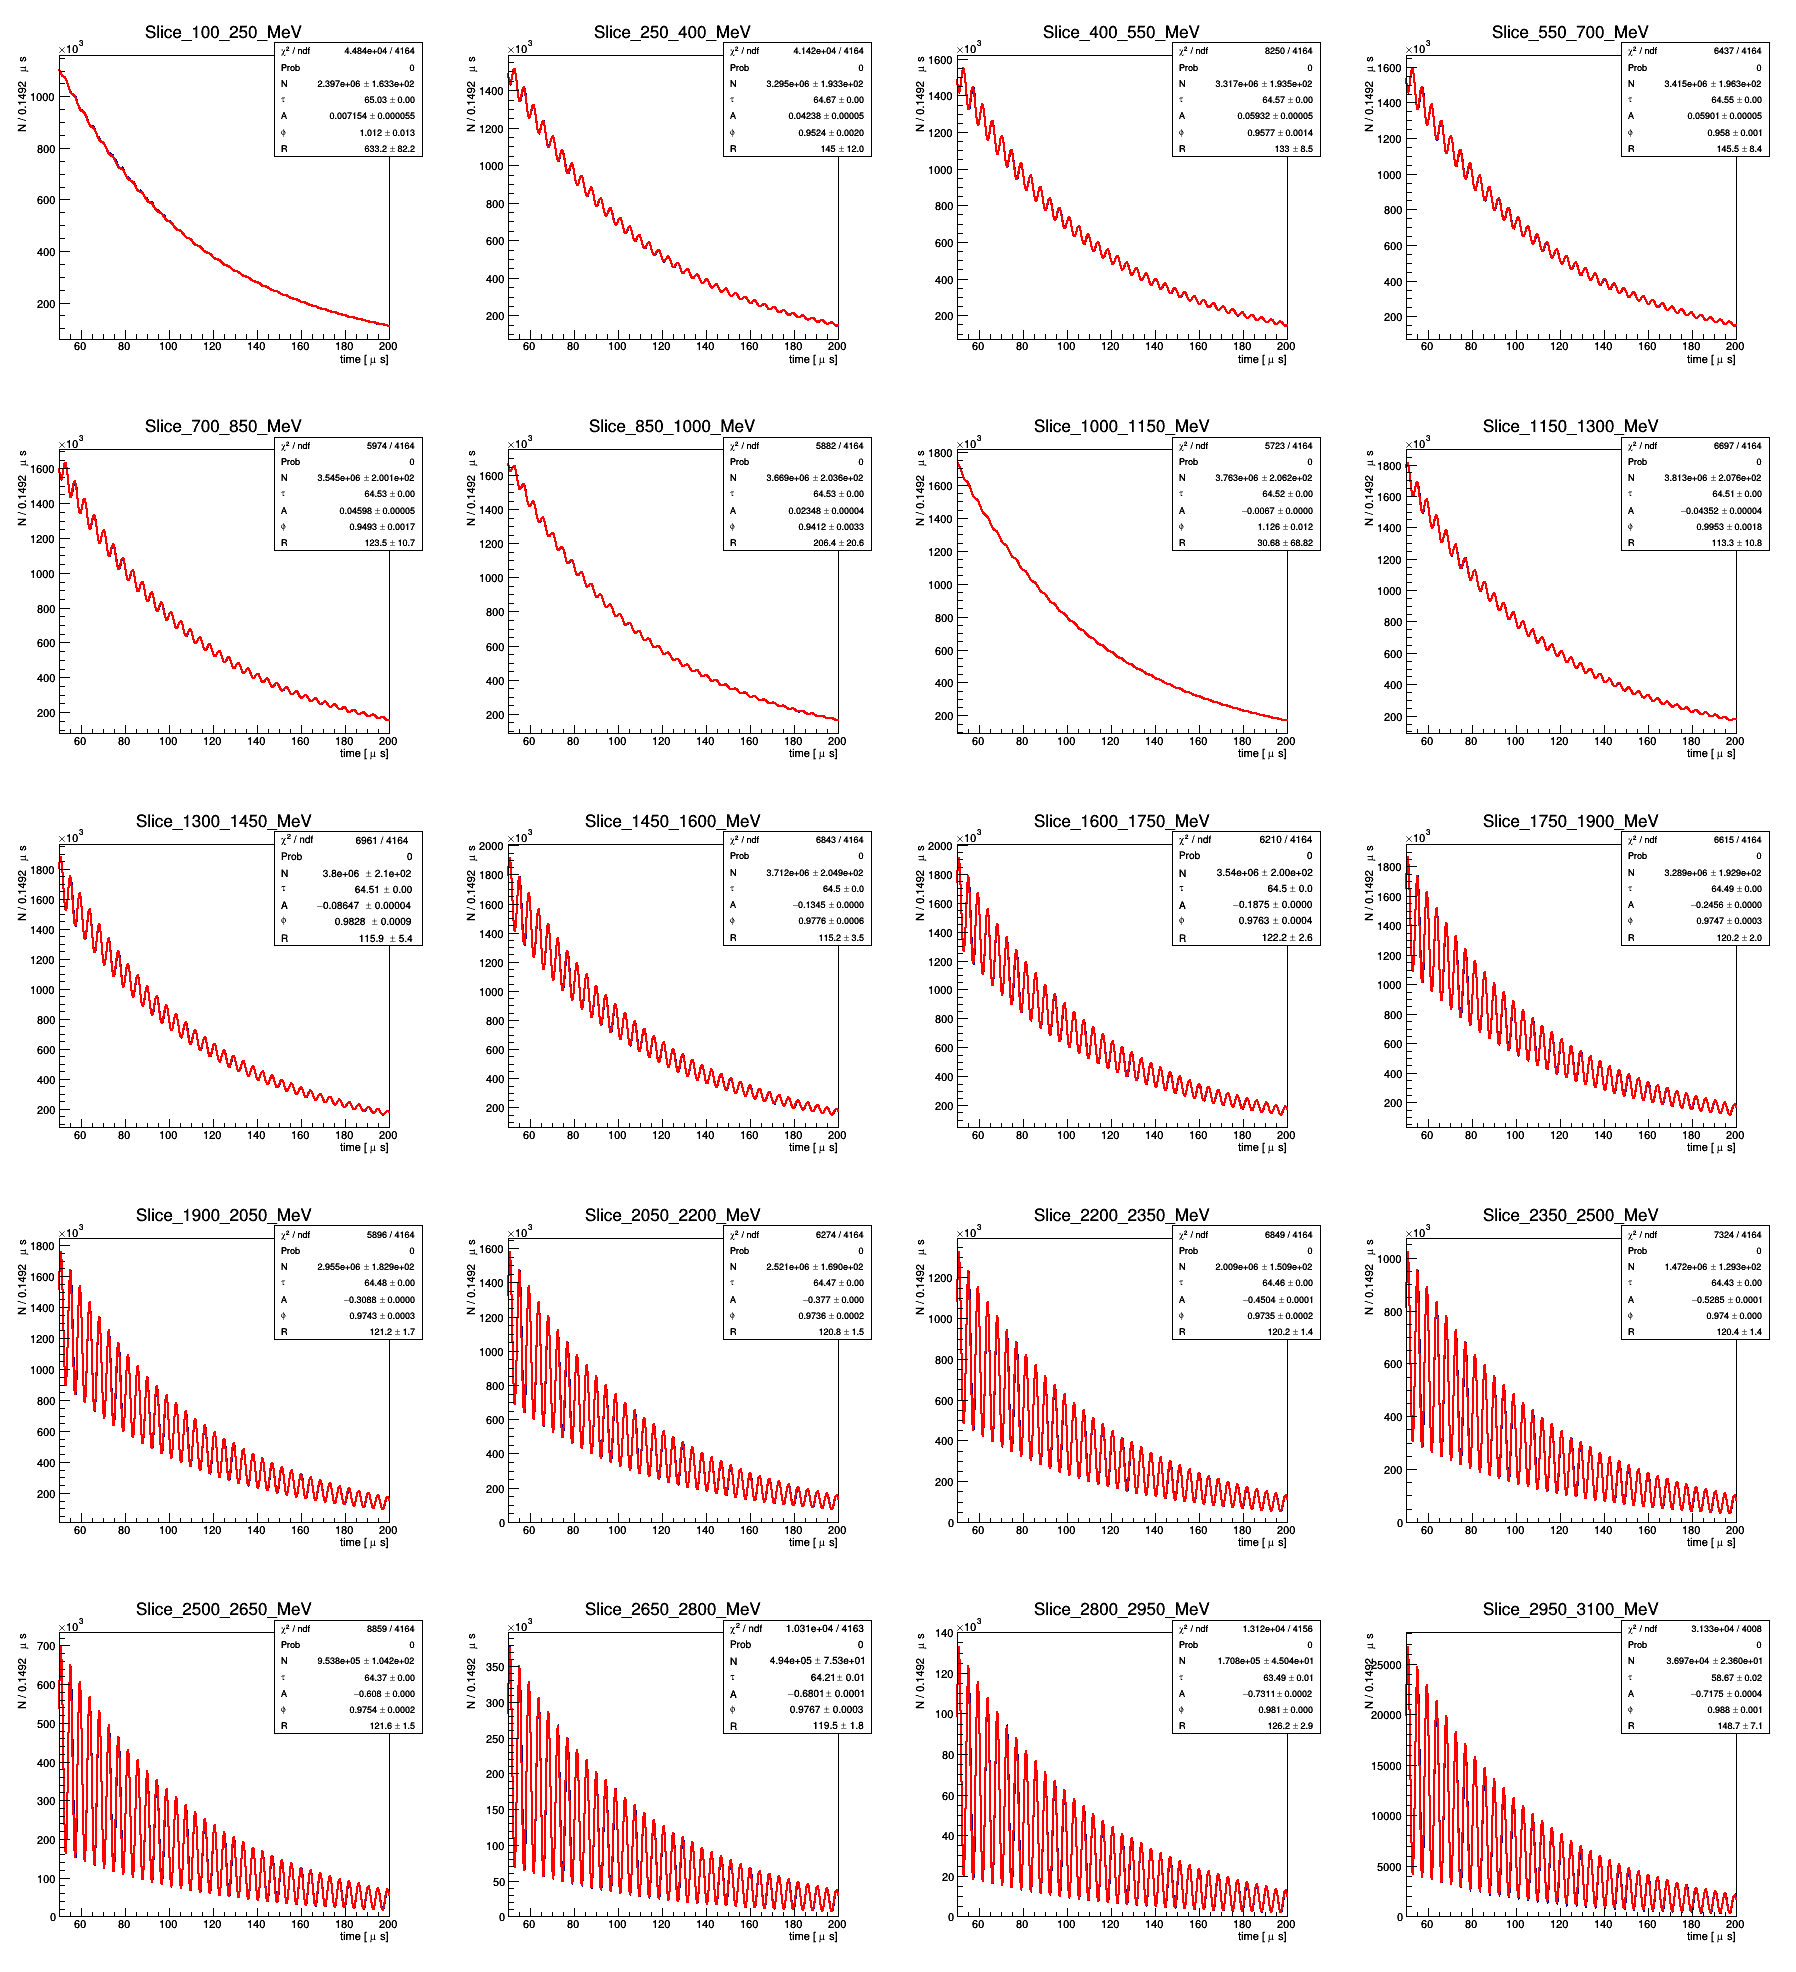

In [23]:
#draw slices wiggles
# canvases = []
# for h in hists_eslice_e:
#     canvases.append(R.TCanvas())
#     h.GetXaxis().SetRangeUser(50,200)
#     h.Draw()
#     canvases[-1].Draw()
#draw slices wiggles
canvas = R.TCanvas('e_slice_e','e_slice_e',1800,2000)
canvas.Divide(4,5)
for n,h in enumerate(hists_eslice_e):
    canvas.cd(n+1)    
    # pad = R.TPad('pad%s'%(n),'pad%s'%(n),0,0,1,1)
    # pad.Draw()
    # pad.cd()
    # pads.append(pad)
    h.GetXaxis().SetTitleOffset(1)
    h.GetYaxis().SetTitleOffset(1.6)
    
    # pad.SetLeftMargin(0.1)
    h.GetXaxis().SetRangeUser(50,200)
    h.SetStats(0)
    h.SetStats(1)
    h.Draw()
canvas.cd(0)
canvas.Draw()    


In [24]:
# #draw parameters vs slices
# canvases = []
# R.gStyle.SetOptFit(0)
# for n in range(5):    
#     canvases.append(R.TCanvas())
#     central_graphs[n].GetHistogram().SetStats(0)
#     central_graphs[n].SetTitle('{0:} versus E-slice; Energy bin center [MeV]; {0:}'.format(namesPhase[n]))
#     central_graphs[n].Fit('pol0')
#     central_graphs[n].GetFunction('pol0').SetLineColor(R.kBlue)    
#     # (central_graphs[n].GetFunction('stats')).Delete()
#     central_graphs[n].Draw('ap')
#     canvases[-1].Draw()




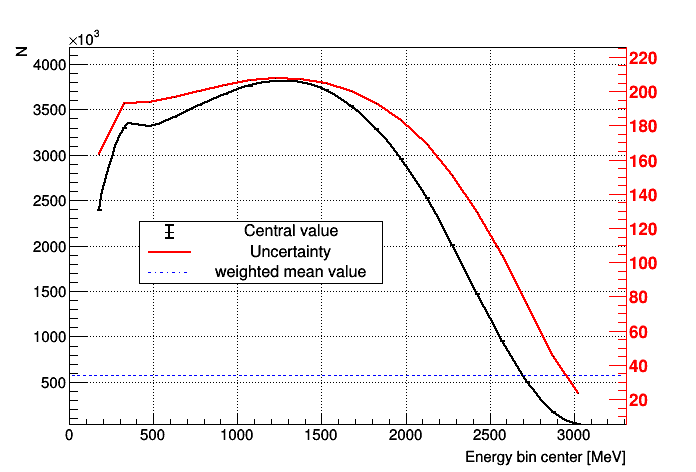

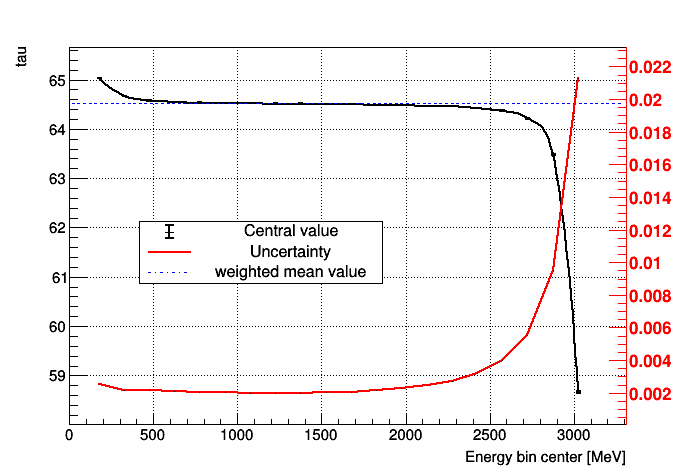

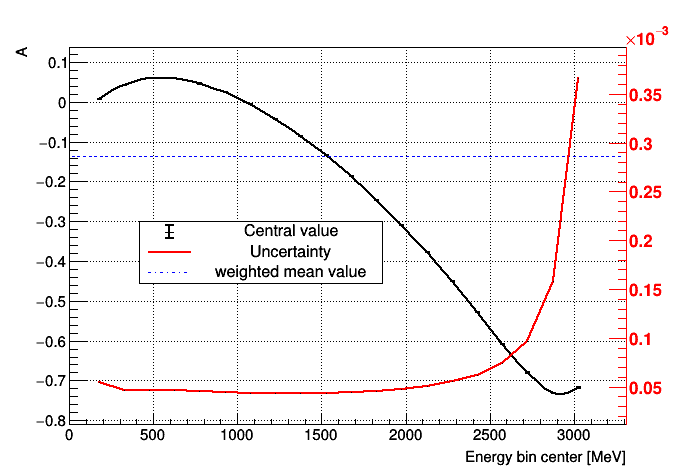

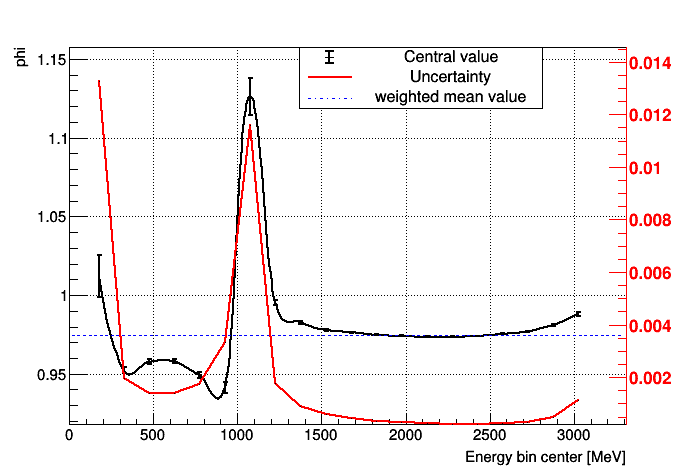

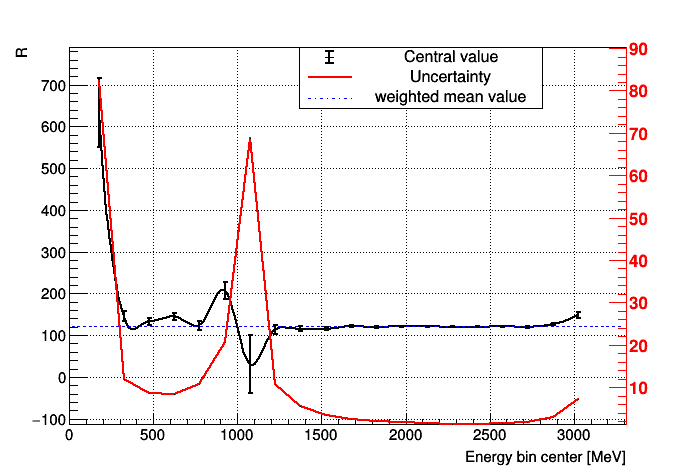

In [25]:
canvases = []
legPos = [
    [0.2,0.4],
    [0.2,0.4],
    [0.2,0.4],
    [0.43,0.77],
    [0.43,0.77]
]
for n in range(5):    
    c = Draw_graph_and_error(central_graphs_eslice_e[n],error_graphs_eslice_e[n],True,legPos[n])
    canvases.append(c)
    c[0].Draw()


In [26]:
#energy slices scan with equal stats
R.gStyle.SetOptFit(1111)
R.gStyle.SetOptStat(0)
central_graphs_eslice_n = [R.TGraphErrors() for n in range(5)]
error_graphs_eslice_n = [R.TGraph() for n in range(5)]
name_temp = 'E_slices_%s_%s'
#setup graphs 
for n in range(5):
    central_graphs_eslice_n[n].SetName(name_temp%(namesPhase[n],'graph'))
    error_graphs_eslice_n[n].SetName(name_temp%(namesPhase[n],'error'))
    central_graphs_eslice_n[n].SetTitle(';%s;%s'%('Energy bin center [MeV]',namesPhase[n]))
    error_graphs_eslice_n[n].SetTitle(';%s;%s'%('Energy bin center [MeV]',namesPhase[n]))
#do scan
hists_eslice_n = []
phase_fit.SetParameters(5e+7, 66.38, 0.1, 0.1, 116.,omega_a_ref)
for nSlice,bin_limit in enumerate(bin_limits_equal):
    e_bin_center = ( bin_limit[0] + bin_limit[1] - 1. )*e_bin_width/2.    
    wiggle = FitScan_energySlices(bin_limit,th2_all,phase_fit)
    hists_eslice_n.append(wiggle)
    for n in range(5):
        value = phase_fit.GetParameter(n)
        error = phase_fit.GetParError(n)
        central_graphs_eslice_n[n].SetPoint(nSlice,e_bin_center,value)
        central_graphs_eslice_n[n].SetPointError(nSlice,0.,error)
        error_graphs_eslice_n[n].SetPoint(nSlice,e_bin_center,error)

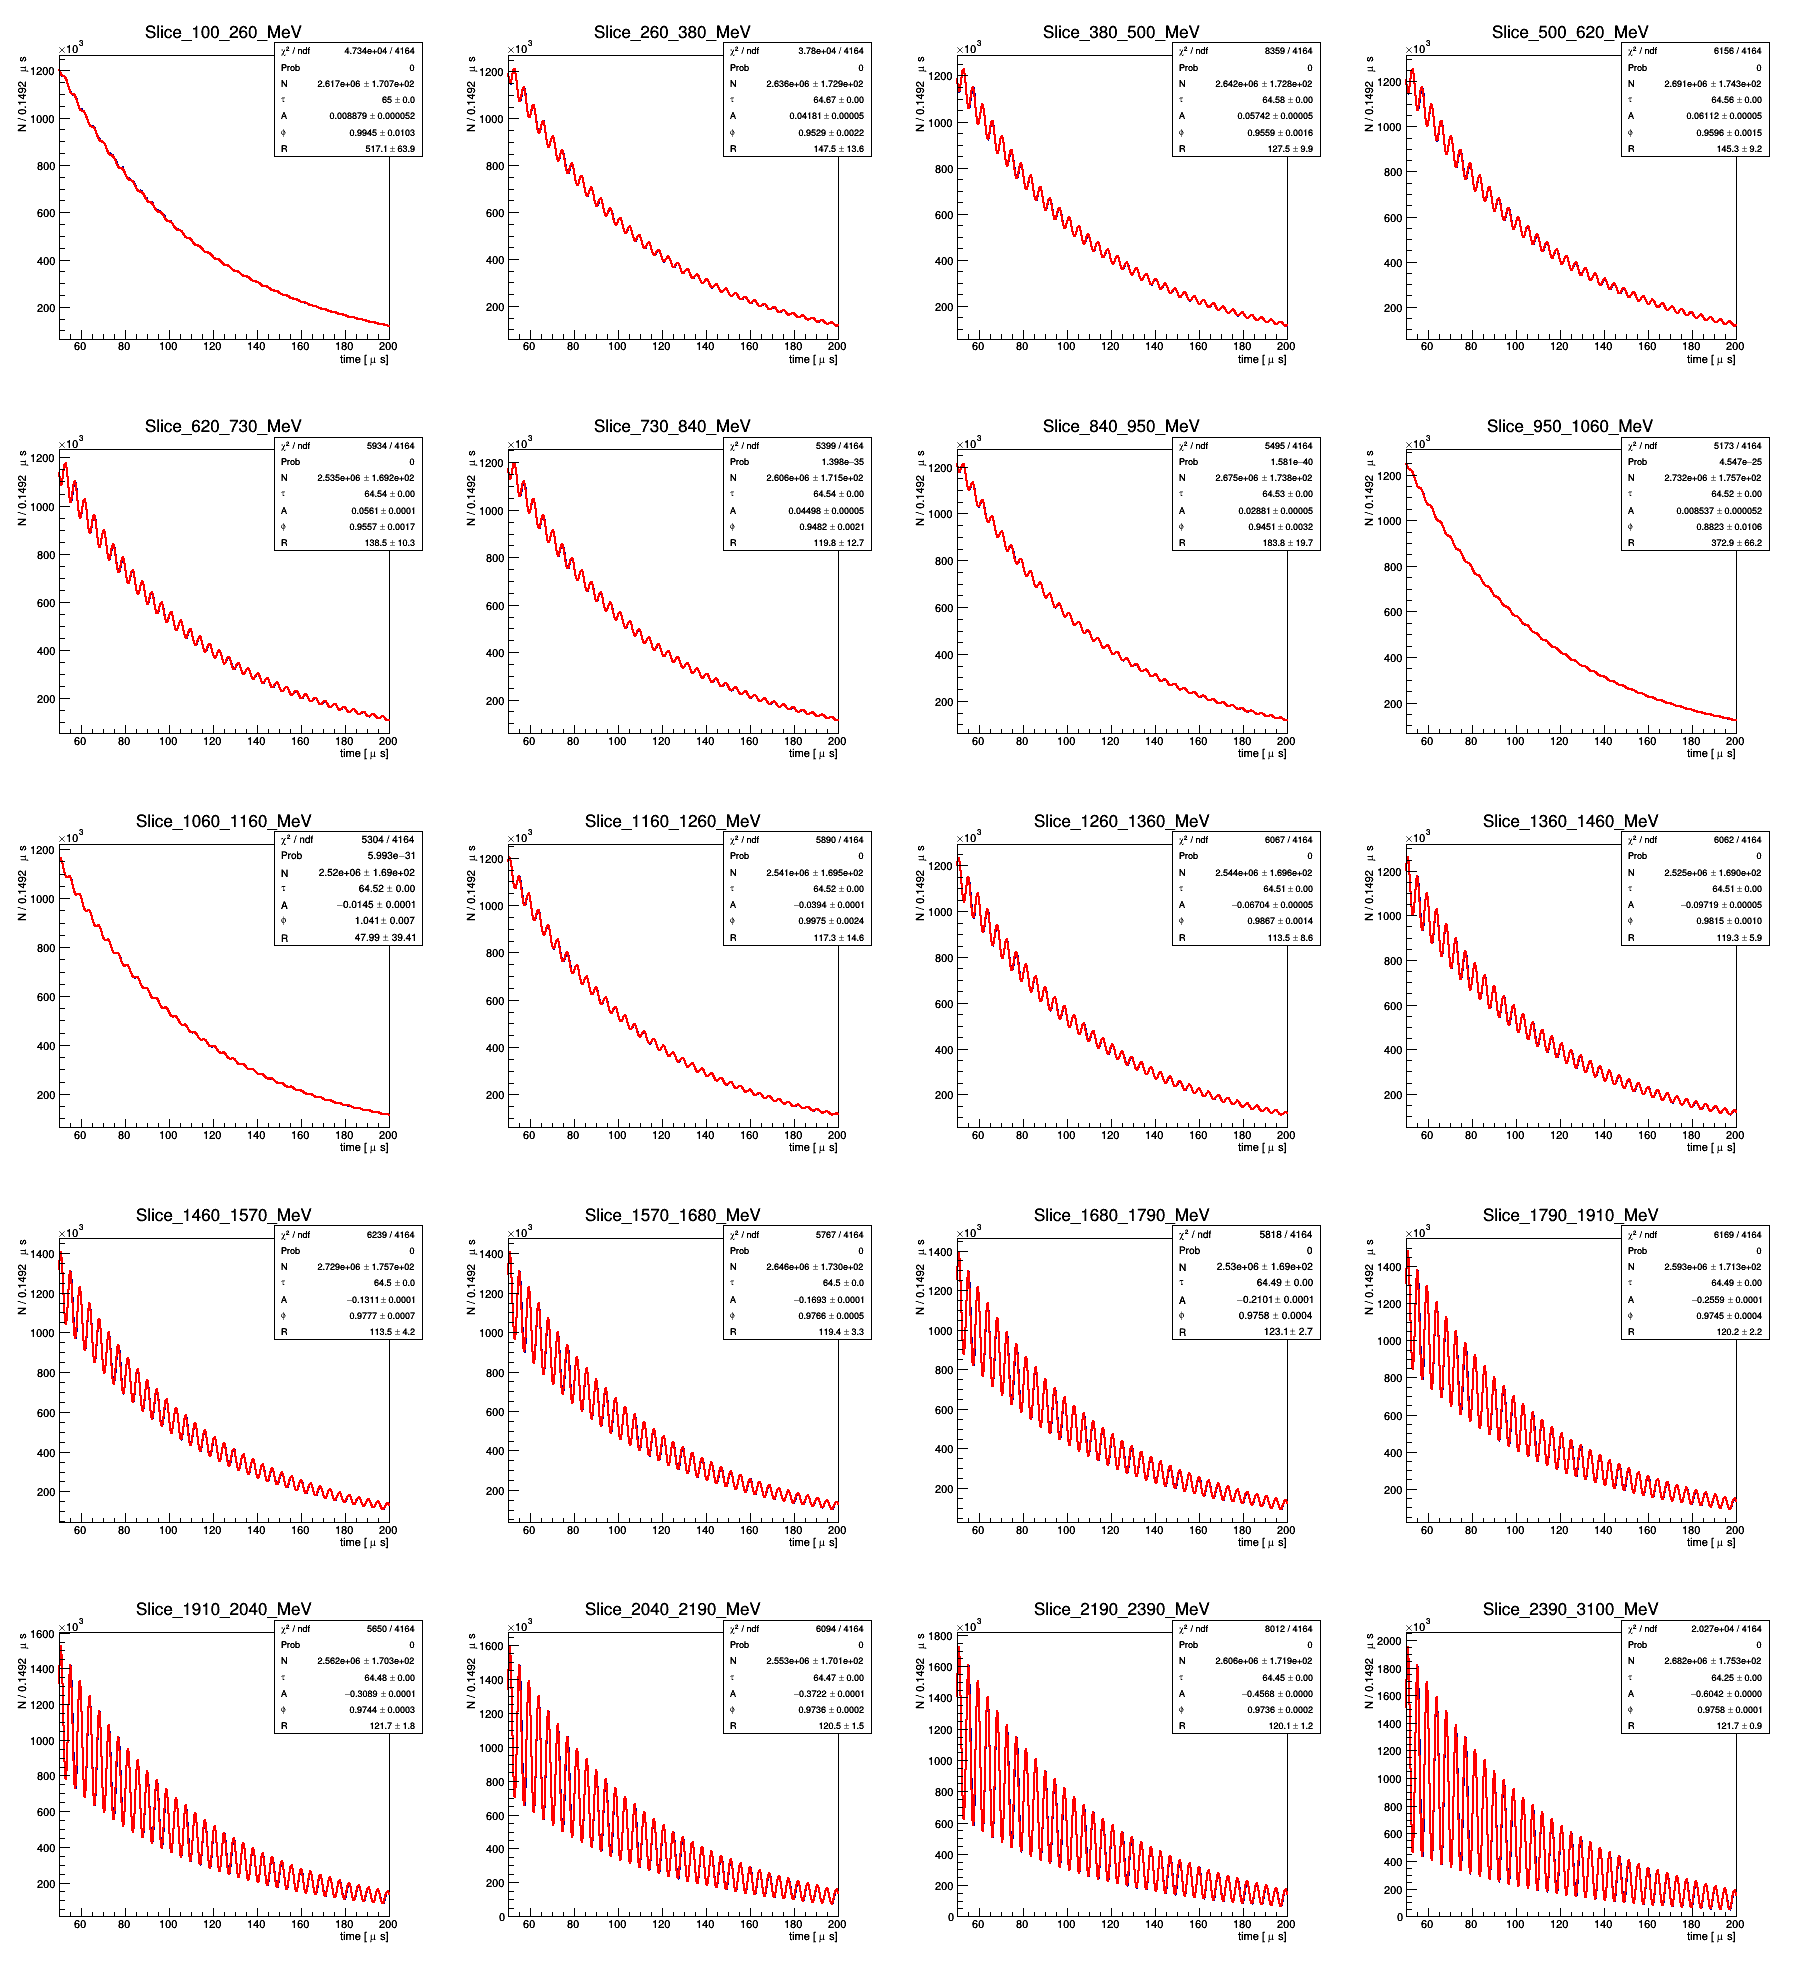

In [27]:
#draw slices wiggles
canvas = R.TCanvas('e_slice_n','e_slice_n',1800,2000)
pads = []
canvas.Divide(4,5)
for n,h in enumerate(hists_eslice_n):
    canvas.cd(n+1)    
    # pad = R.TPad('pad%s'%(n),'pad%s'%(n),0,0,1,1)
    # pad.Draw()
    # pad.cd()
    # pads.append(pad)
    h.GetXaxis().SetTitleOffset(1)
    h.GetYaxis().SetTitleOffset(1.6)
    
    # pad.SetLeftMargin(0.1)
    h.GetXaxis().SetRangeUser(50,200)
    h.SetStats(0)
    h.SetStats(1)
    h.Draw()
canvas.cd(0)
canvas.Draw()


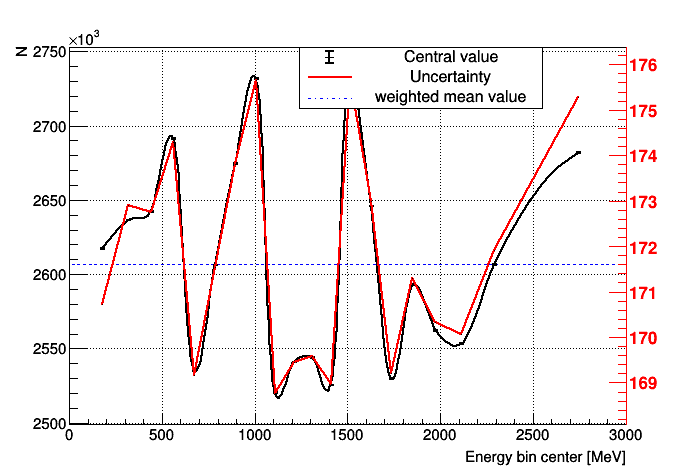

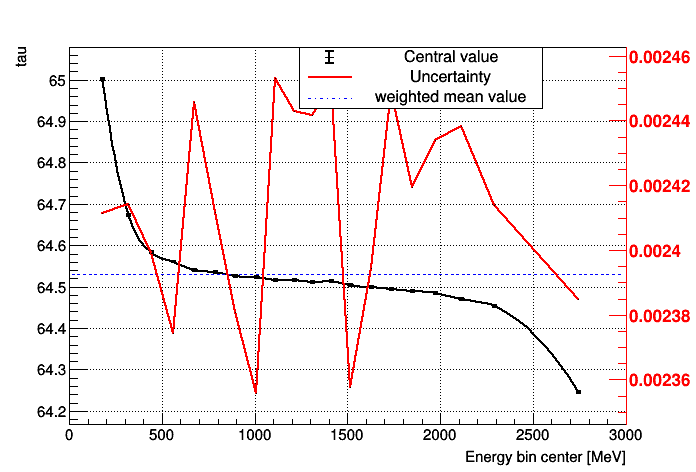

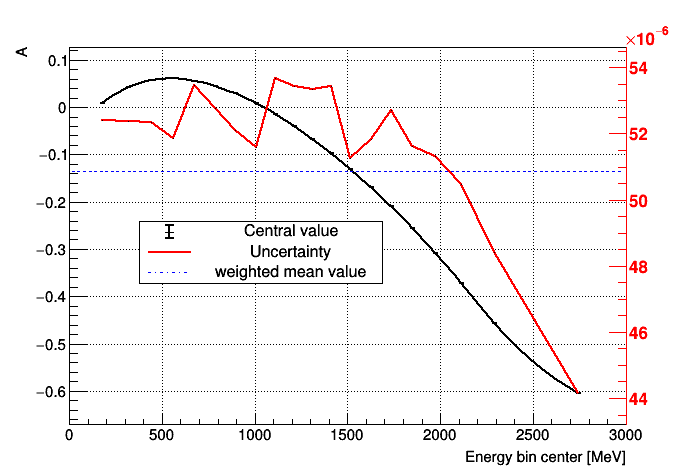

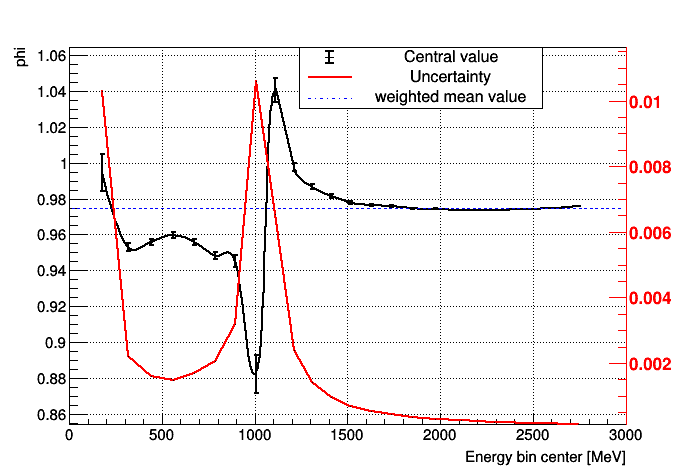

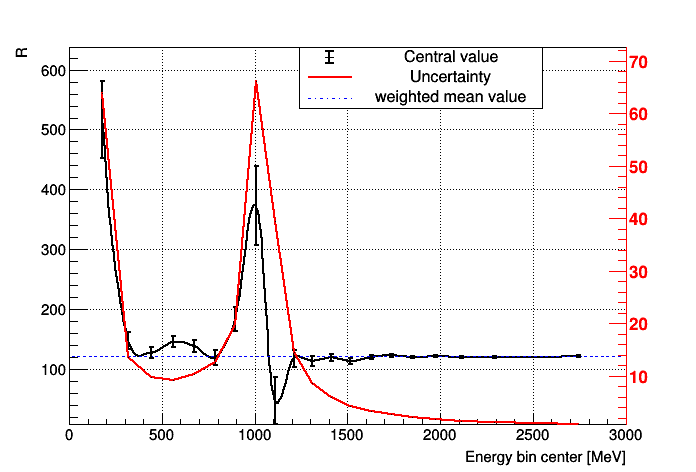

In [28]:
canvases = []
# 0.43, 0.77, 0.78, 0.90
legPos = [
    [0.43,0.77],
    [0.43,0.77],
    [0.2,0.4],
    [0.43,0.77],
    [0.43,0.77]
]
for n in range(5):    
    c = Draw_graph_and_error(central_graphs_eslice_n[n],error_graphs_eslice_n[n],True,legPos[n])
    canvases.append(c)
    c[0].Draw()


In [29]:
#calo by calo fitting
#threshold cut applied
R.gStyle.SetOptFit(1111)
central_graphs_calos = [R.TGraphErrors() for n in range(5)]
error_graphs_calos = [R.TGraph() for n in range(5)]
name_temp = 'Calos_%s_%s'
#setup graphs 
for n in range(5):
    central_graphs_calos[n].SetName(name_temp%(namesPhase[n],'graph'))
    error_graphs[n].SetName(name_temp%(namesPhase[n],'error'))
    central_graphs_calos[n].SetTitle(';%s;%s'%('Calorimeter number',namesPhase[n]))
    error_graphs_calos[n].SetTitle(';%s;%s'%('Calorimeter number',namesPhase[n]))
#do scan
hists_calos = []
phase_fit.SetParameters(5e+6, 66.38, 0.1, 0.1, 116.,omega_a_ref)
t_method_bin = th2_all.GetYaxis().FindBin(e_thresh)
NbinsY = th2_all.GetNbinsY()
for nCalo in range(24):
    th2 = th2_calos[nCalo]    
    wiggle = th2.ProjectionX('%s'%(nCalo),t_method_bin,NbinsY)
    wiggle.SetTitle('calorimeter: {0:}; time [#mu s]; N / {1} #mu s'.format(nCalo, t_bin_width))
    PhaseFit(wiggle,phase_fit,t_start,t_end)
    hists_calos.append(wiggle)
    for n in range(5):
        value = phase_fit.GetParameter(n)
        error = phase_fit.GetParError(n)
        central_graphs_calos[n].SetPoint(nCalo,nCalo,value)
        central_graphs_calos[n].SetPointError(nCalo,0.,error)
        error_graphs_calos[n].SetPoint(nCalo,nCalo,error)

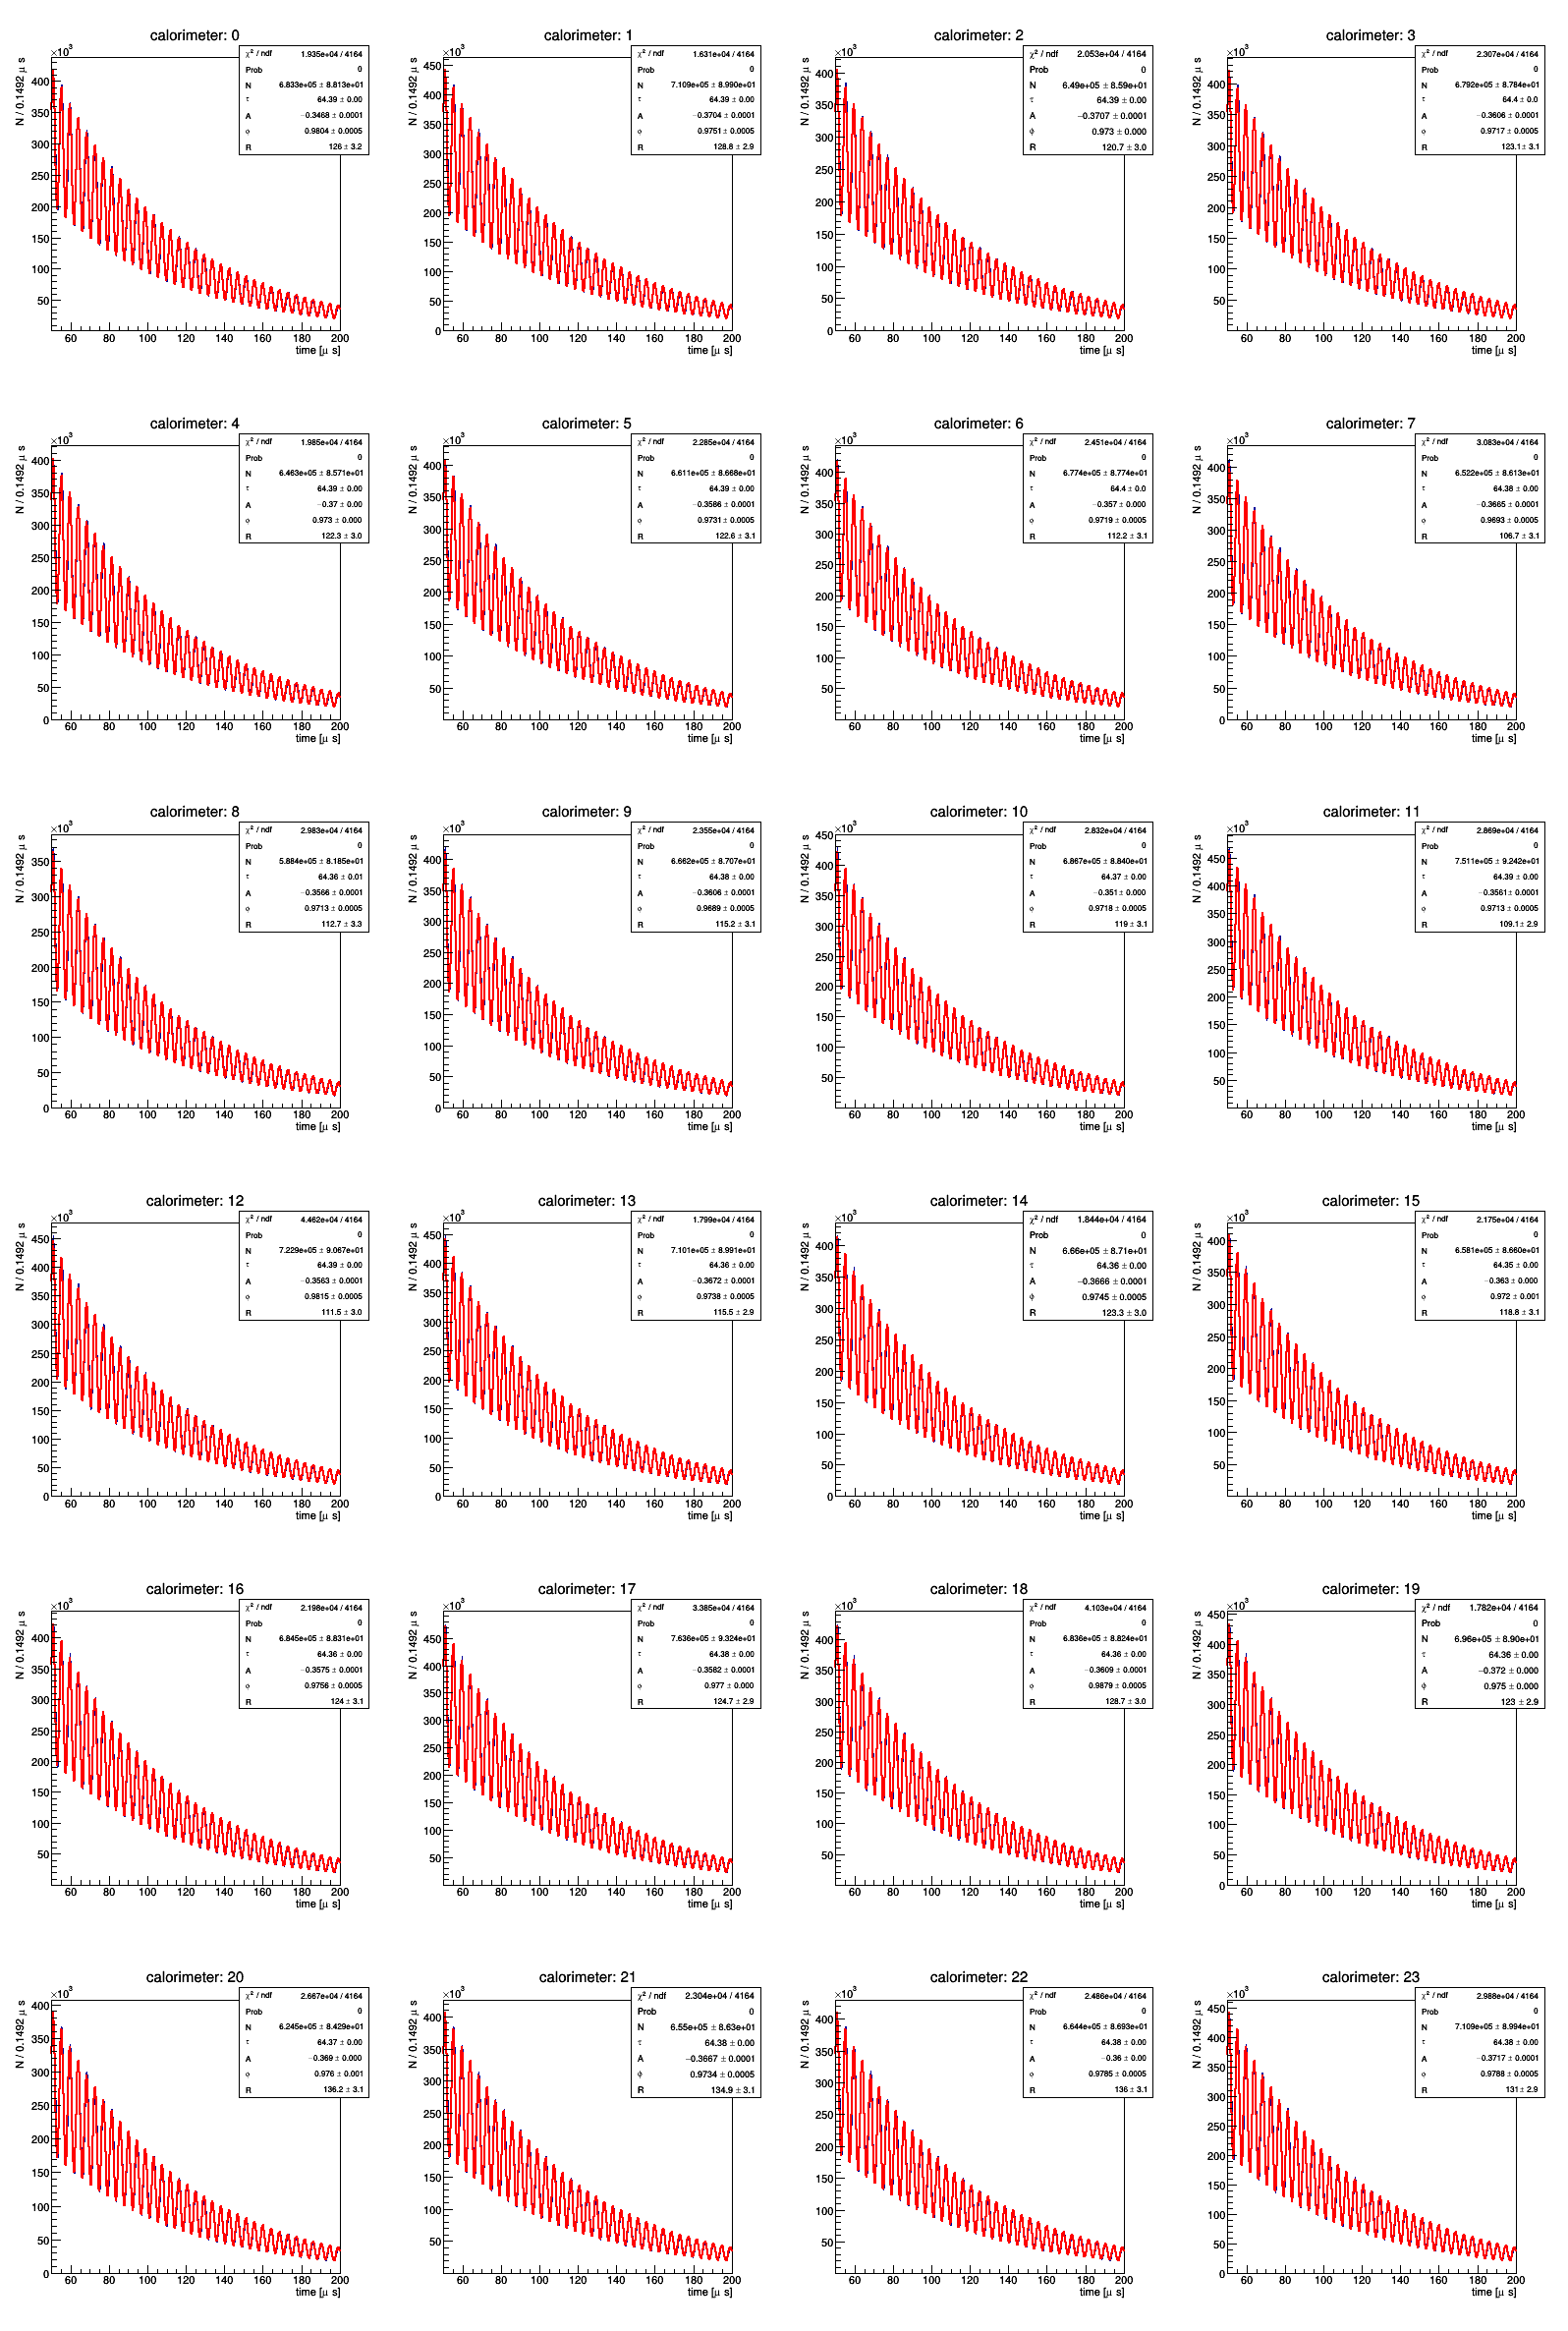

In [30]:
#draw calo wiggles
canvas = R.TCanvas('calo_wiggles','calo_wiggles',1600,2400)
canvas.Divide(4,6)
for n,h in enumerate(hists_calos):
    canvas.cd(n+1)
    h.GetXaxis().SetRangeUser(50,200)
    h.SetStats(0)
    h.SetStats(1)
    h.GetYaxis().SetTitleOffset(1.5)
    h.Draw()
canvas.cd(0)
canvas.Draw()


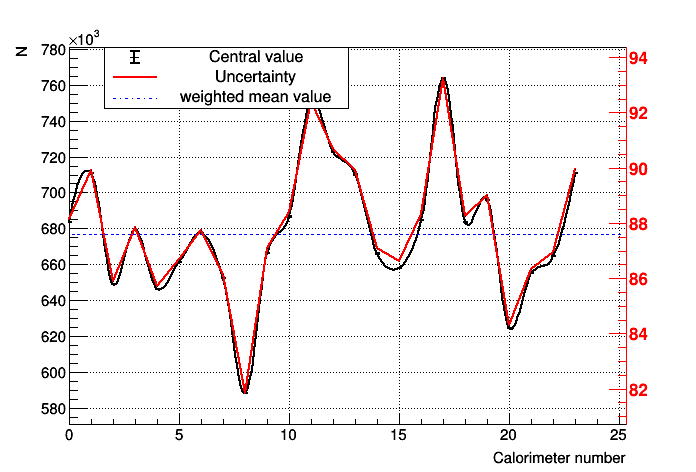

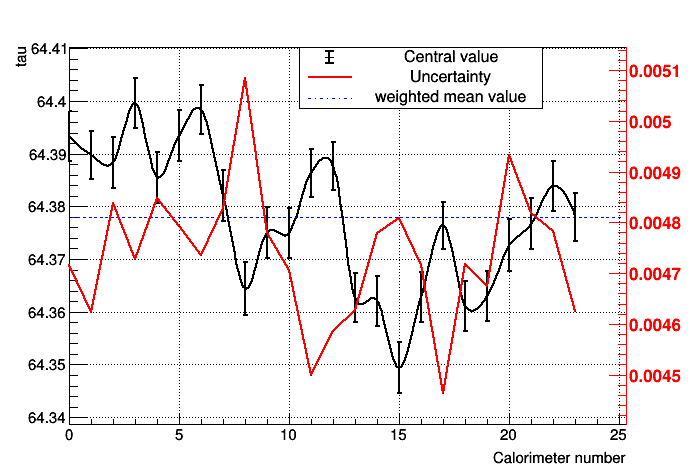

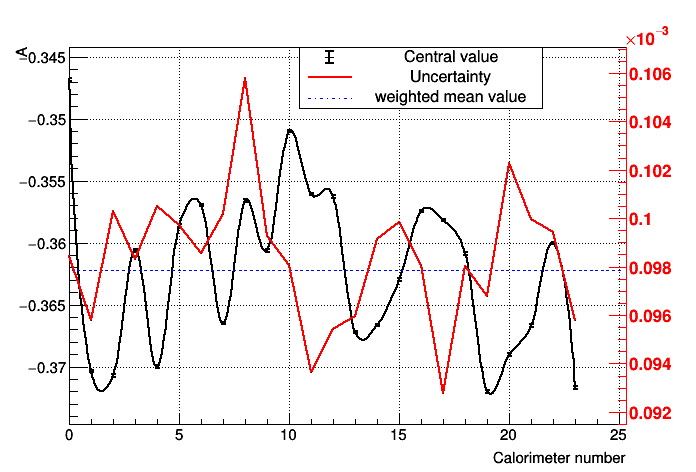

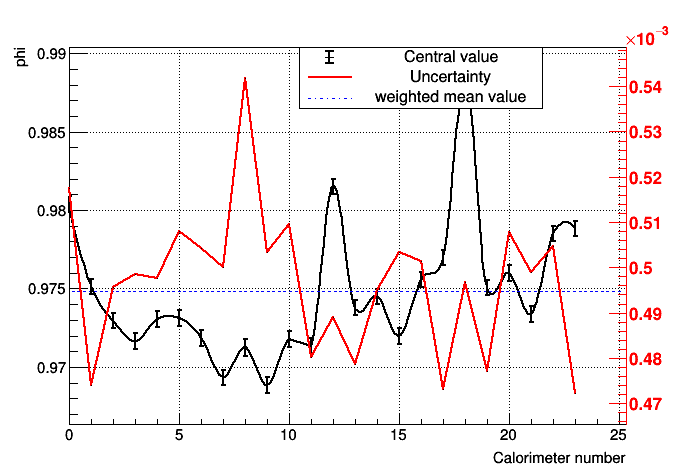

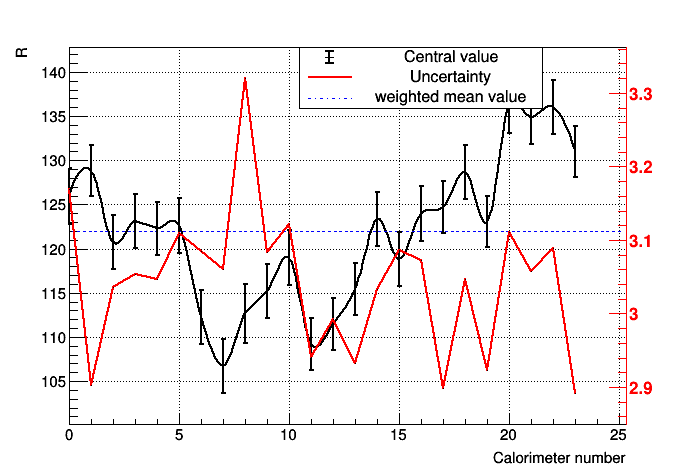

In [31]:
#draw parameters by calorimeters
canvases = []
legPos = [
    [0.15,0.77],
    [0.43,0.77],
    [0.43,0.77],
    [0.43,0.77],
    [0.43,0.77]
]
for n in range(5):    
    c = Draw_graph_and_error(central_graphs_calos[n],error_graphs_calos[n],True,legPos[n])
    canvases.append(c)
    c[0].Draw()

In [32]:
#analysis residuals
residuals = []
for ncalo,hist in enumerate(hists_calos):
    residual = hist.Clone()
    residual.GetXaxis().SetRangeUser(t_start,300)
    residual.SetName('residual_calo_{0:}'.format(nCalo))    
    for nBin in range(1,residual.GetNbinsX()+1):
        bin_center = residual.GetXaxis().GetBinCenter(nBin)
        fit_val = hist.GetFunction('phasefit').Eval(bin_center)
        bin_content = hist.GetBinContent(nBin)
        residual.SetBinContent(nBin,bin_content - fit_val)
    residuals.append(residual)

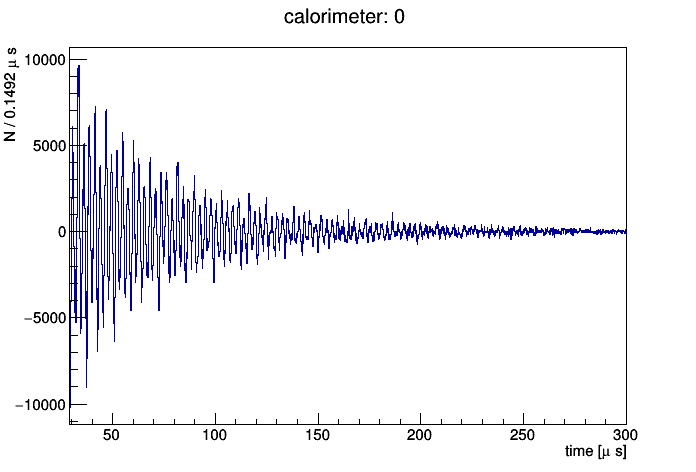

In [33]:
#draw residual calo 0
canvas = R.TCanvas()
residuals[0].Draw('HIST')
canvas.Draw()

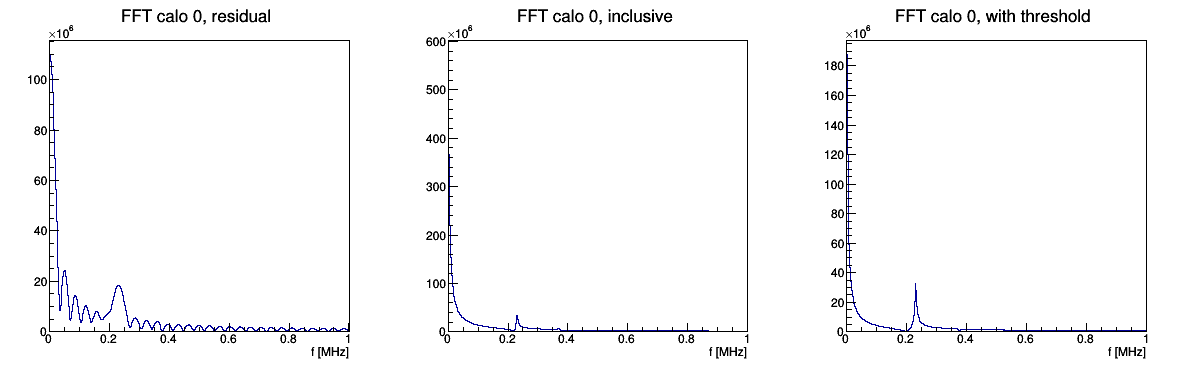

In [34]:
#FFT for calo 0: residual, threshold on, threshold off
NbinsX = hists_calos[0].GetNbinsX()
nCalo = 0
fft_hist = R.TH1F('FFT{0:}'.format(nCalo),'FFT calo {0:};f [MHz]'.format(nCalo),NbinsX,0,1./t_bin_width)
#residual
fft_residual = fft_hist.Clone()
fft_residual.SetName('FFT calo {0:}, residual '.format(nCalo))
fft_residual.SetTitle('FFT calo {0:}, residual '.format(nCalo))
residual.FFT(fft_residual,'MAG')
#threshold off
fft_thres_off = fft_hist.Clone()
fft_thres_off.SetName('FFT calo {0:}, thres off '.format(nCalo))
fft_thres_off.SetTitle('FFT calo {0:}, inclusive '.format(nCalo))
th2_calos[nCalo].ProjectionX().FFT(fft_thres_off,'MAG')
#threshold on
fft_thres_on = fft_hist.Clone()
fft_thres_on.SetName('FFT calo {0:}, thres on '.format(nCalo))
fft_thres_on.SetTitle('FFT calo {0:}, with threshold '.format(nCalo))
hists_calos[nCalo].FFT(fft_thres_on,'MAG')
canvas = R.TCanvas('FFT{0:}'.format(nCalo),'FFT{0:}'.format(nCalo),1200,400)

canvas.Divide(3)
canvas.cd(1)
fft_residual.GetXaxis().SetRangeUser(0,1)
fft_residual.Draw()

canvas.cd(2)
fft_thres_off.GetXaxis().SetRangeUser(0,1)
fft_thres_off.Draw()

canvas.cd(3)
fft_thres_on.GetXaxis().SetRangeUser(0,1)
fft_thres_on.Draw()

canvas.cd(0)
canvas.Draw()

In [35]:
def endpoint_line(x, p):
    return p[0]*x[0] - p[0]*p[1]

def FindPoint(hist,ratio):
    cumulative = hist.GetCumulative()
    maximum = cumulative.GetMaximum()
    return cumulative.GetBinLowEdge(cumulative.FindFirstBinAbove(maximum*ratio))

def FindPointFast(cumulative,maximum,ratio):
    return cumulative.GetBinLowEdge(cumulative.FindFirstBinAbove(maximum*ratio))

fit_func = R.TF1('fit_func', endpoint_line, 0, 3200, 2)
fit_func.SetParNames('slope', 'endpoint [MeV]')
fit_func.SetLineColor(R.kRed)

In file included from input_line_265:1:
In file included from /Applications/root_v6.24.00/include/CPyCppyy/API.h:30:
In file included from /usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/include/python2.7/Python.h:88:
/usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/include/python2.7/unicodeobject.h:534:5: warning: 'register' storage class specifier is deprecated and incompatible with C++17 [-Wdeprecated-register]
    register PyObject *obj,     /* Object */
    ^~~~~~~~~
/usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/include/python2.7/unicodeobject.h:553:5: warning: 'register' storage class specifier is deprecated and incompatible with C++17 [-Wdeprecated-register]
    register PyObject *obj      /* Object */
    ^~~~~~~~~
/usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/include/python2.7/unicodeobject.h:575:5: warning: 'register' storage class specifier is deprecated and incompa

In [76]:
def FitEndPoint(hist,fitModel,start,end):
    cumulative = hist.GetCumulative()
    cumulative_max = cumulative.GetMaximum()
    start_fit = cumulative.GetBinLowEdge(cumulative.FindFirstBinAbove(cumulative_max*start))
    end_fit = cumulative.GetBinLowEdge(cumulative.FindFirstBinAbove(cumulative_max*end)+1)
    hist.Fit(fitModel, 'EQM','',start_fit, end_fit)
    endpoint_val = fitModel.GetParameter(1)
    endpoint_err = fitModel.GetParError(1)
    slope_val = fitModel.GetParameter(0)
    slope_err = fitModel.GetParError(0)    
    chi2_ndf = fit_func.GetChisquare()/fit_func.GetNDF()
    return [slope_val,slope_err,endpoint_val,endpoint_err,chi2_ndf]

In [38]:
#found the fitting region
energy_dist_all = th2_all.ProjectionY()
cumulative = energy_dist_all.GetCumulative()
maximum = cumulative.GetMaximum()
start = 0.85
chi2 = []
for n in range(100):
    start = 0.85 + n*0.001
    M = (0.95 - start)/0.001
    chi2.append([])
    for m in range(int(M)):        
        fit_func.SetParameters(-6.e4,3000.)
        end = start + 0.05 + m * 0.001 
        start_fit = FindPointFast(cumulative,maximum,start)
        end_fit = FindPointFast(cumulative,maximum,end)
        energy_dist_all.Fit(fit_func, 'EQM','',start_fit, end_fit)
        c2 = fit_func.GetChisquare()
        ndf = fit_func.GetNDF()
        p0 = fit_func.GetParameter(0)
        p1 = fit_func.GetParameter(1)
        chi2[-1].append([p0,p1,c2,ndf])

100
99
63 63 1.87965261479


Warning in <TFile::Append>: Replacing existing TH1: chi2/ndf (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: chi2/ndf (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: endpointFitOpt


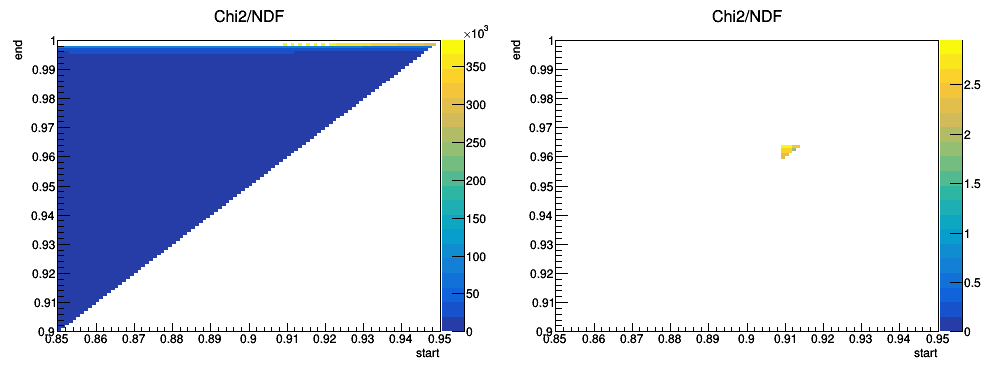

In [40]:
th2_chi2_ndf = R.TH2D('chi2/ndf',';start;end',100,0.85,0.95,100,0.9,1.0)
th2_chi2_ndf.SetTitle('Chi2/NDF;start;end')
th2_chi2_ndf_filter = th2_chi2_ndf.Clone()
print len(chi2)
print len(chi2[0])
for n in range(100):
    start = 0.85 + n*0.001
    M = (0.95 - start)/0.001    
    for m in range(int(M)):
        end = start + 0.05 + m * 0.001        
        c2 = chi2[n][m][2]/chi2[n][m][3]
        th2_chi2_ndf.SetBinContent(n,n+m,c2)
        if c2 < 3:
            th2_chi2_ndf_filter.SetBinContent(n,n+m,c2)
        if c2 < 2:
            print n,n+m,c2
canvas = R.TCanvas('endpointFitOpt','endpointFitOpt',1000,400)
R.gStyle.SetOptStat(0)
canvas.Divide(2)
canvas.cd(1)
th2_chi2_ndf.Draw('COLZ')
th2_chi2_ndf.GetYaxis().SetTitleOffset(1.5)
canvas.cd(2)
th2_chi2_ndf_filter.Draw('COLZ')
th2_chi2_ndf_filter.GetYaxis().SetTitleOffset(1.5)
canvas.cd(0)
canvas.Draw()

In [77]:
#fit endpoints of calos
fit_res = []
hists_endpoint = []
start = 0.913
end = 0.963
for nCalo,th2_calo in enumerate(th2_calos):
    fit_func.SetParameters(-3.5e3,3000)
    hists_endpoint.append(th2_calo.ProjectionY())
    res = FitEndPoint(hists_endpoint[-1],fit_func,start,end)
    fit_res.append(res)
#fit endpoint overall
fit_func.SetParameters(-6.e4,3000.)
hist_endpoint = th2_all.ProjectionY()
fit_res_all = FitEndPoint(hist_endpoint,fit_func,start,end)


2834.5000722 yes
c_double(2240.0) c_double(2470.0)
2


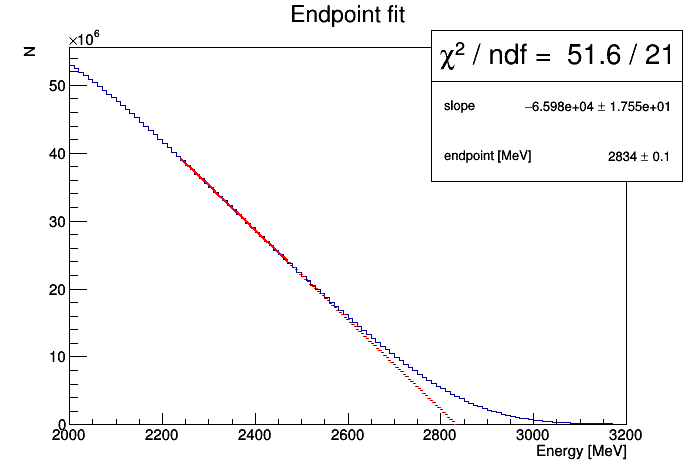

In [78]:
R.gStyle.SetOptFit(111)
R.gStyle.SetOptStat(0)
grapherr_endpoints = R.TGraphErrors()
graph_chi2_endpoints = R.TGraph()
hist_endpoint.GetXaxis().SetRangeUser(2000,3200)
hist_endpoint.GetFunction('fit_func').SetLineColor(R.kRed)
# hist_endpoint.GetFunction('fit_func').SetLineStyle(1)
func_extra = fit_func.Clone()
start_fit = ctypes.c_double(0.)
end_fit = ctypes.c_double(0.)
hist_endpoint.GetFunction('fit_func').GetRange(start_fit,end_fit)


func_extra.SetParameters(fit_res_all[0],fit_res_all[2])
print fit_res_all[2],'yes'
func_extra.SetRange(end_fit,3000)
print start_fit,end_fit
func_extra.SetLineWidth(1)
func_extra.SetLineStyle(2)
canvas = R.TCanvas()
hist_endpoint.SetTitle('Endpoint fit;Energy [MeV];N')
hist_endpoint.Draw()
func_extra.Draw('esame')
canvas.Draw()
print hist_endpoint.GetFunction('fit_func').GetLineWidth()

In [85]:
# print fit_res_all
# print fit_res
graph_err_endpoint = R.TGraphErrors()
graph_chi2_endpoint = R.TGraph()
graph_err_endpoint.SetTitle('Endpoints;Calorimeter number;Extrapolated endpoint [MeV]')
for nCalo,fit_res_calo in enumerate(fit_res):
    graph_err_endpoint.SetPoint(nCalo,nCalo,fit_res_calo[2])
    graph_err_endpoint.SetPointError(nCalo,0.,fit_res_calo[3])
    graph_chi2_endpoint.SetPoint(nCalo,nCalo,fit_res_calo[4])

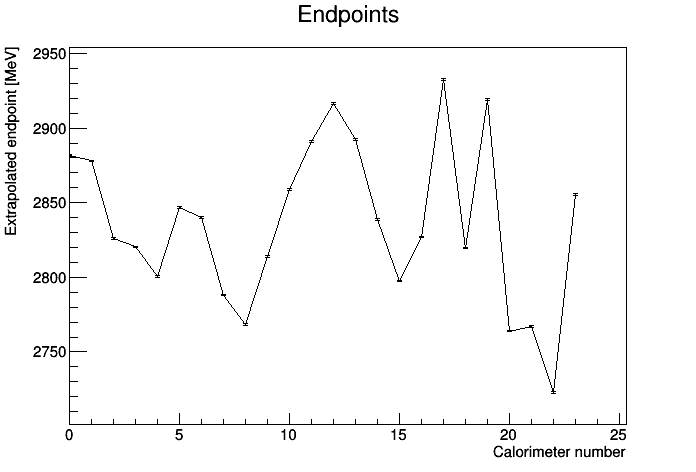

In [105]:
#draw parameters by calorimeters
c = R.TCanvas()

graph_err_endpoint.Draw('alp')

c.Draw()